<a href="https://colab.research.google.com/github/NNRahat/PyTorch_projects/blob/main/Copy_of_03_computer_vision_real_prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np


import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None 
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)
len(train_data), len(test_data)

100%|██████████| 26421880/26421880 [00:03<00:00, 8270135.01it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 143252.26it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2669973.36it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20389307.83it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(60000, 10000)

In [ ]:
class_name = train_data.classes
class_name 

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

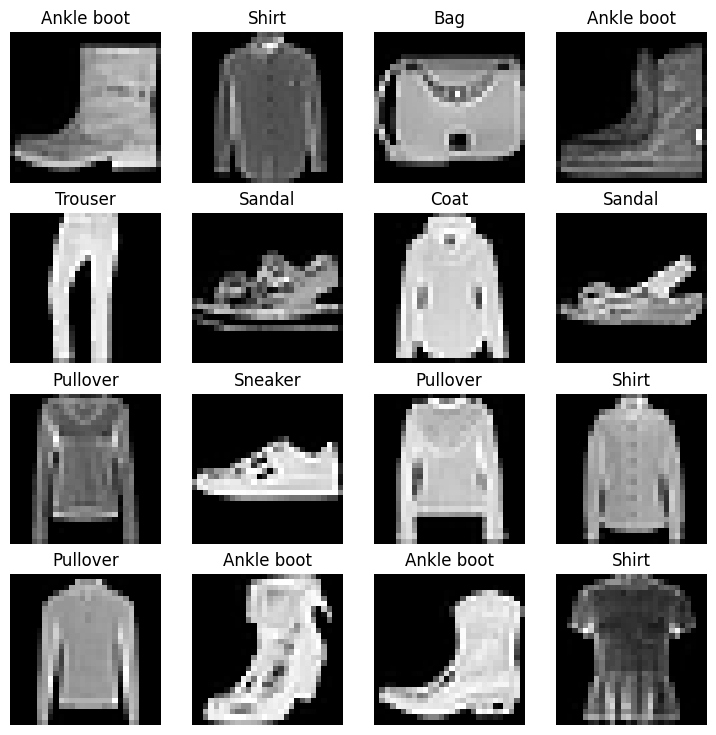

In [ ]:
# sample 
torch.manual_seed(42)
plt.figure(figsize = (9,9))
rows, cols = 4,4

for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx] 
  plt.subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_name[label])
  plt.axis(False)


In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_function.py already exists!! so skipping")
else:
  print("downloading helper_function.py!!!")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


downloading helper_function.py!!!


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_data_loader = DataLoader(dataset = train_data,
                               batch_size = BATCH_SIZE,
                               shuffle = True)
test_data_loader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

In [ ]:
# create the model 
class FashionMNISTV2(nn.Module):
  def __init__(self, input_shape : int,
               hidden_units : int,
               output_shape : int):
    super().__init__()
    self.Linear_Stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )

  def forward(self, x):
    return self.Linear_Stack(x)

In [ ]:
model_2 = FashionMNISTV2(input_shape = 784,
                         hidden_units = 10,
                         output_shape = len(class_name))
model_2

FashionMNISTV2(
  (Linear_Stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [ ]:
from timeit import default_timer as timer
def print_time(start : float,
               end : float,
               device = None):
  total_time = end - start 
  print(f"The time on device: {device} is {total_time}seconds")
  return total_time 

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc



In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)

start_time_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  model_2.train()
  train_loss, train_acc = 0, 0
  for batch,(X,y) in enumerate(train_data_loader):
    #forward the pass
    y_train_preds = model_2(X)

    # calculate the loss
    loss = loss_fn(y_train_preds, y)
    train_loss += loss

    # accuracy
    acc = accuracy_fn(y_true = y, y_pred = y_train_preds.argmax(dim=1))
    train_acc += acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    
    if batch % 400 == 0:
      print(f"looked at {batch*len(X)} / {len(train_data_loader.dataset)}")

  train_loss /= len(train_data_loader)
  train_acc /= len(train_data_loader)


  test_loss, test_acc = 0, 0 
  model_2.eval()
  with torch.inference_mode():
    for X_test, y_test in test_data_loader:
      y_test_preds = model_2(X_test)

      test_loss += loss_fn(y_test_preds, y_test)
      test_acc += accuracy_fn(y_true = y_test, y_pred = y_test_preds.argmax(dim=1))
    
    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

  ## print out whats happening
  print(f"Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

end_time_on_cpu = timer()
total_time = print_time(start=start_time_on_cpu,
                        end = end_time_on_cpu,
                        device = str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
looked at 0 / 60000
looked at 12800 / 60000
looked at 25600 / 60000
looked at 38400 / 60000
looked at 51200 / 60000
Train loss: 0.63080, Train accuracy: 77.27% | Test loss: 0.53192, Test accuracy: 81.18%
Epoch: 1
looked at 0 / 60000
looked at 12800 / 60000
looked at 25600 / 60000
looked at 38400 / 60000
looked at 51200 / 60000
Train loss: 0.49828, Train accuracy: 82.43% | Test loss: 0.49852, Test accuracy: 82.30%
Epoch: 2
looked at 0 / 60000
looked at 12800 / 60000
looked at 25600 / 60000
looked at 38400 / 60000
looked at 51200 / 60000
Train loss: 0.47526, Train accuracy: 83.26% | Test loss: 0.49794, Test accuracy: 83.17%
The time on device: cpu is 32.77520631099998seconds


In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0 , 0
    for X, y in tqdm(data_loader):
      X = X.to(device)
      y = y.to(device)
      test_preds = model(X)
      #calculate the loss
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y_true= y, y_pred = test_preds.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  return {"model name" : model_2.__class__.__name__,
          "test acc" : test_acc,
          "test loss" : test_loss.item()}

model_eval = eval_model(model = model_2,
                        data_loader = test_data_loader,
                        loss_fn = loss_fn,
                        accuracy_fn = accuracy_fn,
                        device = "cpu")

model_eval



  0%|          | 0/313 [00:00<?, ?it/s]

{'model name': 'FashionMNISTV2',
 'test acc': 83.16693290734824,
 'test loss': 0.4979401230812073}

In [ ]:
next(model_2.parameters()).device


device(type='cpu')

## next model with gpu

In [ ]:
class FashionMNISTV3(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.Non_Linear_Stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    ) 
  def forward(self, x):
    return self.Non_Linear_Stack(x)


In [ ]:
torch.manual_seed(42)
model_3 = FashionMNISTV3(input_shape = 784,
                         hidden_units = 10,
                         output_shape = len(class_name)).to(device)
next(model_3.parameters()).device

device(type='cuda', index=0)

In [ ]:
next(model_2.parameters()).device

device(type='cpu')

In [ ]:
## loss function
loss_fn = nn.CrossEntropyLoss()

## optimizer 
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr = 0.1)

In [ ]:
def train_steps(model : torch.nn.Module,
                data_loader : torch.utils.data.DataLoader,
                loss_fn : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                accuracy_fn,
                device : torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X,y) in enumerate(data_loader):
    # put data to target device
    X, y = X.to(device), y.to(device)

    # forward the pass 
    train_preds = model(X)
    # calculate the loss / acc 
    loss = loss_fn(train_preds, y)
    train_loss += loss 

    # accuracy 
    acc = accuracy_fn(y_true = y, y_pred = train_preds.argmax(dim=1))
    train_acc += acc

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward 
    loss.backward()

    # optimizer step step step
    optimizer.step()


  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss:{train_loss:.4f}, train accuracy:{train_acc:.2f}%")

#### test function
def test_steps(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device:torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      # put data to target device
      X, y = X.to(device), y.to(device)

      # forward the pass
      test_preds = model(X)

      # loss / acc 
      test_loss += loss_fn(test_preds, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_preds.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  
  print(f"Test loss:{test_loss:.4f}, test_accuracy:{test_acc:.2f}%")
  
  

In [ ]:
torch.manual_seed(42)
epochs = 3
start_time_on_gpu = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----------------\n")
  train_steps(model = model_3,
              data_loader = train_data_loader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              accuracy_fn = accuracy_fn)
  
  test_steps(model = model_3,
             data_loader = test_data_loader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn)
  
end_time_on_gpu = timer()

total_time = print_time(start = start_time_on_gpu,
                        end = end_time_on_gpu,
                        device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 ----------------

Train loss:1.0920, train accuracy:61.34%
Test loss:0.9564, test_accuracy:65.00%
Epoch: 1 ----------------

Train loss:0.7810, train accuracy:71.93%
Test loss:0.7223, test_accuracy:73.91%
Epoch: 2 ----------------

Train loss:0.6703, train accuracy:75.94%
Test loss:0.6850, test_accuracy:75.02%
The time on device: cuda is 38.17480151999996seconds


## starting of the CNN chapter

In [ ]:
class FashionMNISTModelV3(nn.Module):
  def __init__(self, 
               input_shape : int,
               hidden_units : int,
               output_shape: int):
    super().__init__()
    self.Conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, 
                  out_channels=hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.Conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, 
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, 
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features = output_shape)
    )
  def forward(self, x):
    x = self.Conv_block_1(x)
    # print(x.shape)
    x = self.Conv_block_2(x)
    # print(x.shape)
    x = self.Classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_4 = FashionMNISTModelV3(input_shape = 1, # the image has only one color channel, image shape = [1, 28, 28]
                              hidden_units = 10,
                              output_shape = len(class_name)).to(device)
model_4

FashionMNISTModelV3(
  (Conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
train_batch_features,train_batch_label= next(iter(train_data_loader))
train_batch_features.shape


torch.Size([32, 1, 28, 28])

Text(0.5, 1.0, 'Shirt')

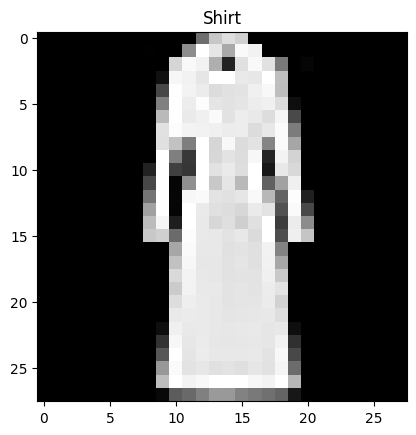

In [ ]:
torch.manual_seed(42)
random_id = torch.randint(0, len(train_batch_features), size=[1]).item()
image = train_batch_features[random_id]
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_name[random_id])

In [ ]:
## loss function
loss_fn = nn.CrossEntropyLoss()
## optimizer
optimizer = torch.optim.SGD(params = model_4.parameters(),
                            lr = 0.1)

## training and testing using function

In [ ]:
torch.manual_seed(42)

epochs = 3
start_time_on_gpu = timer()

for epoch in tqdm(range(epochs)):
  print(f"\nEpoch: {epoch} \n---------------")
  train_steps(model = model_4,
              data_loader = train_data_loader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              accuracy_fn = accuracy_fn)
  test_steps(model = model_4,
             data_loader = test_data_loader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn)

end_time_on_gpu = timer()
total_time = print_time(start = start_time_on_gpu,
                        end = end_time_on_gpu,
                        device = device)
              


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0 
---------------
Train loss:0.5939, train accuracy:78.42%
Test loss:0.3908, test_accuracy:86.00%

Epoch: 1 
---------------
Train loss:0.3638, train accuracy:86.89%
Test loss:0.3572, test_accuracy:86.71%

Epoch: 2 
---------------
Train loss:0.3223, train accuracy:88.27%
Test loss:0.3432, test_accuracy:87.78%
The time on device: cuda is 45.75592365700004seconds


In [ ]:
model_4_results = eval_model(model = model_4,
                             data_loader = test_data_loader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device = device)
model_4_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model name': 'FashionMNISTV2',
 'test acc': 87.77955271565496,
 'test loss': 0.34319424629211426}

 ## make prediction
 

In [ ]:
def make_predictions(model : torch.nn.Module,
                     data : list,
                     device : torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample and add batch size
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # forward pass (raw logits)
      pred_logit = model(sample).squeeze()

      # logit -> pred probs
      pred_prob = torch.softmax(pred_logit, dim=0)

      # get pred_prob out of gpu i.e to cpu
      pred_probs.append(pred_prob.cpu())
  
  # stack the pred probs to turn the list into tensors 
  return torch.stack(pred_probs)
      

In [ ]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Dress')

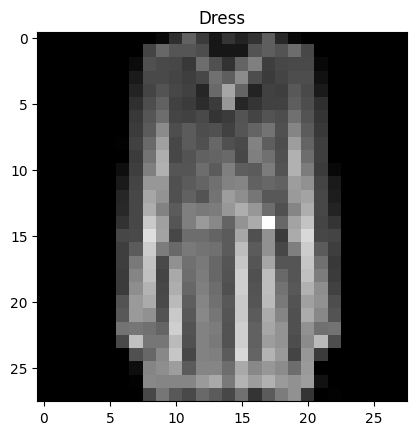

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_name[test_labels[0]])

In [ ]:
pred_probs = make_predictions(model = model_4,
                              data = test_samples)
pred_probs[:2]

tensor([[8.4699e-02, 2.5820e-02, 1.1116e-01, 5.0089e-01, 1.1508e-01, 1.8539e-03,
         1.5218e-01, 3.2133e-04, 7.8264e-03, 1.6950e-04],
        [9.4390e-05, 8.9399e-06, 4.8885e-05, 1.0636e-04, 6.6300e-06, 9.9766e-01,
         7.1799e-05, 1.3757e-03, 1.0219e-04, 5.2750e-04]])

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 5, 0, 5, 4, 1, 4, 7, 5])

In [ ]:
test_labels

[3, 5, 0, 5, 4, 1, 4, 7, 5]

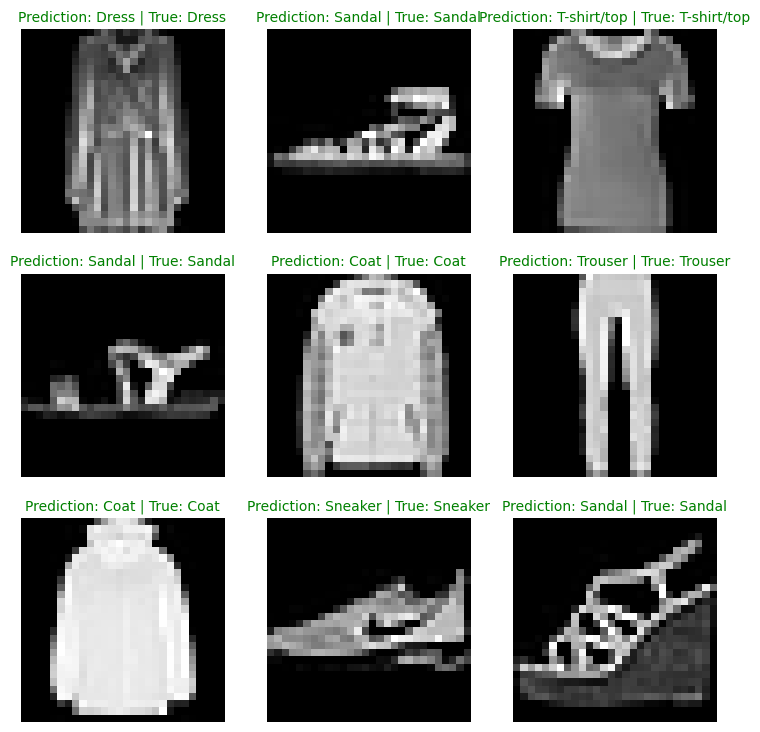

In [ ]:
plt.figure(figsize = (9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap = "gray")

  pred_label = class_name[pred_classes[i]]

  true_label = class_name[test_labels[i]]

  title_text = f"Prediction: {pred_label} | True: {true_label}"

  if pred_label == true_label:
    plt.title(title_text, fontsize= 10, c="g")
  else:
    plt.title(title_text, fontsize = 10, c="r")

  plt.axis(False)

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__split(".")[1] >= 19, "mlxtend should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
   

mlxtend version: 0.22.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mlxtend version: 0.22.0


In [ ]:
from tqdm.auto import tqdm
y_preds = []

for X, y in tqdm(test_data_loader, desc="Making predictions..."):
  X = X.to(device)
  y = y.to(device)

  y_logit = model_4(X).squeeze()

  y_pred = torch.softmax(y_logit, dim=0).argmax(dim=1)

  y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
len(y_pred_tensor)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

10000

In [ ]:
y_pred_tensor

tensor([9, 2, 1,  ..., 8, 1, 8])

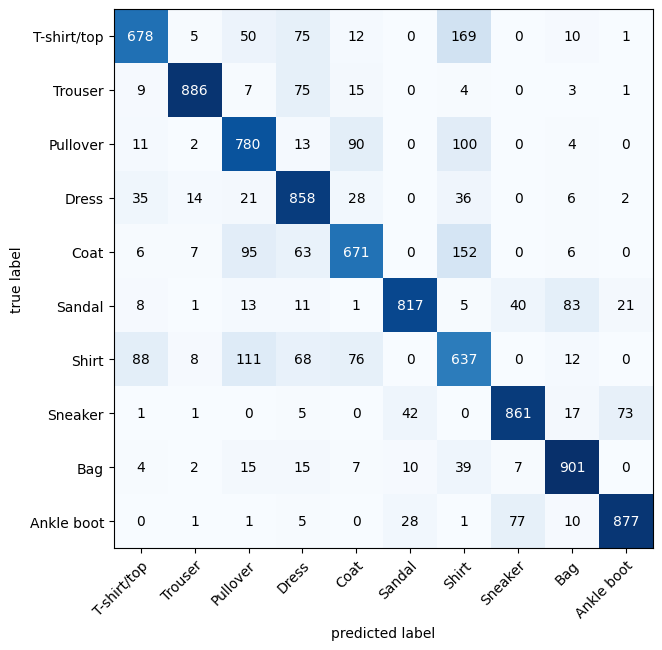

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_name),task = "multiclass") # these are not tensor
# now we have to convert to tensor
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

confmat_tensor


## plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize = (10,7)
)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok= True)

MODEL_NAME = "03_computer_vision_fashionMNIST_model_4.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_4.state_dict(),
           f = MODEL_SAVE_PATH)

saving model to: Models/03_computer_vision_fashionMNIST_model_4.pth
